In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['text.usetex'] = True
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, MFDataset
import numpy as np
import time, os
from scipy.ndimage import filters


In [37]:
simul = "luckym2"

krypton = "/data0/project/vortex/lahaye/"
dirfil = krypton+"{}_modemap/".format(simul)
dirpic = "./pictures/"
filename = simul+'_modenrj.nc'          # netCDF file to read from

dosavefig = True

it = 300
imod = 9

cmap_abs = 'gist_earth_r'
lev_h = [-4000,-3000,-2000,-1000]
lst_h = ['-','-','-','-']
col_h = ['grey','grey','k','k']

pictype = '.png'  # picture output format
fs       = 12       # fontsize
proj     = 'lcc'    # grid projection
res      = 'i'
stride   = 5
grdcol = 'k'        # grid line color
stq = 20                # step for quiver
qcol = 'darkred'       # color of arrows for nrj fluxes
qsc = 5.        # scale for quiver (au pif)
#qwdt = 1.0
blur = 3        # None or #points, bluring for quiver (not sure None renders correct)

rho0 = 1.025e3  # this won't be usefull in future versions

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


<IPython.core.display.Javascript object>


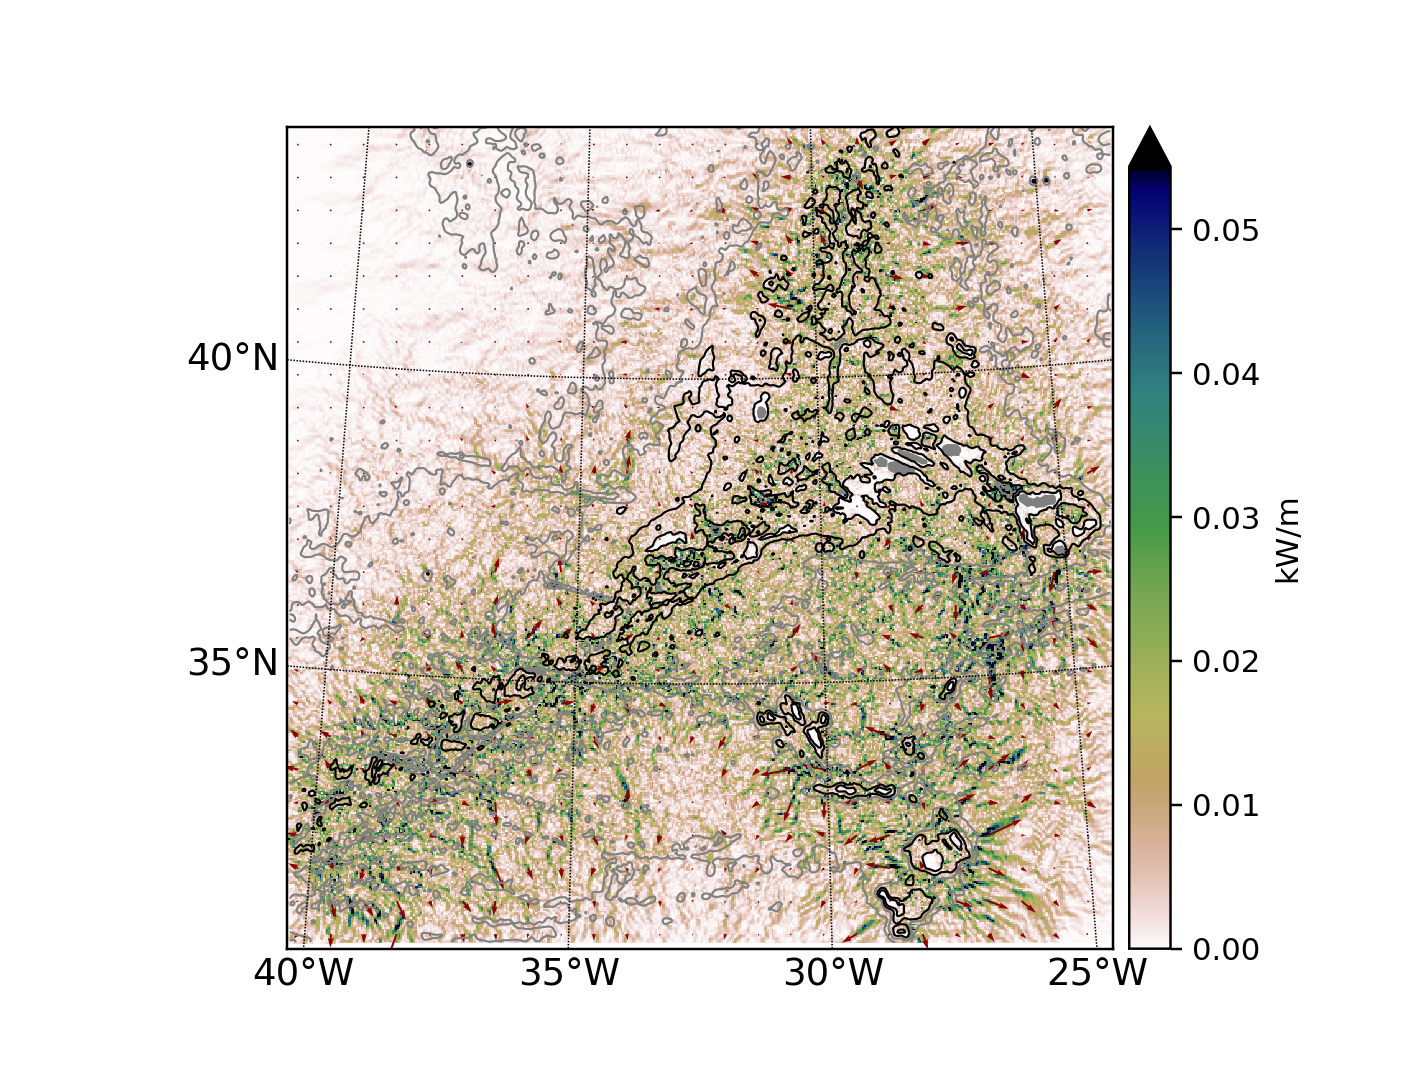

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'latlon'
  s)


In [38]:
# Load data and plot lowf

ncr = Dataset(dirfil+filename,'r')
lon = ncr.variables['lon_rho'][:]   # shape (y,x)
lat = ncr.variables['lat_rho'][:]
topo = -ncr.variables['topo'][:]
Lx = (lon[:,-1].mean() - lon[:,0].mean())*6400e3*np.cos(lat.mean()*np.pi/180.)*np.pi/180.
Ly = (lat[-1,:].mean() - lat[0,:].mean())*6400e3*np.pi/180.
modes = ncr.variables['mode'][imod]

times = ncr.variables['ocean_time'][it]
Fx = np.ma.masked_invalid(ncr.variables['Fx_lf'][it,imod,...])*rho0
Fy = np.ma.masked_invalid(ncr.variables['Fy_lf'][it,imod,...])*rho0
Fnorm = np.sqrt(Fx**2 +Fy**2)
vmax = (Fnorm.mean()+Fnorm.std())*3
        
fig = plt.figure()
ax = plt.subplot(111)
bm = Basemap(projection=proj,resolution=res,\
            lon_0=lon.mean(),lat_0=lat.mean(),\
            width=Lx,height=Ly)
xx,yy = bm(lon,lat) 
slix = slice(stq//4,xx.shape[-1],stq)
sliy = slice(stq//4,xx.shape[0],stq)

# --- map ---                                  
bm.drawcoastlines(color='gray')
bm.fillcontinents(color='gray')
hpar = bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.5,fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.5,fontsize=fs,color=grdcol)
# extend grid for pcolormesh (better to pass edges)
xmesh = np.r_['-1',(1.5*xx[:,0]-0.5*xx[:,1])[:,None],0.5*(xx[:,1:]+xx[:,:-1]),\
                    (1.5*xx[:,-1]-0.5*xx[:,-2])[:,None]]
ymesh = np.r_['-1',(1.5*yy[:,0]-0.5*yy[:,1])[:,None],0.5*(yy[:,1:]+yy[:,:-1]),\
                    (1.5*yy[:,-1]-0.5*yy[:,-2])[:,None]]
xmesh = np.vstack((1.5*xmesh[0,:]-0.5*xmesh[1,:],0.5*(xmesh[1:,:]+xmesh[:-1,:]),\
                    1.5*xmesh[-1,:]-0.5*xmesh[-2,:]))
ymesh = np.vstack((1.5*ymesh[0,:]-0.5*ymesh[1,:],0.5*(ymesh[1:,:]+ymesh[:-1,:]),\
                    1.5*ymesh[-1,:]-0.5*ymesh[-2,:]))
hpc = bm.pcolormesh(xmesh, ymesh, Fnorm, cmap=cmap_abs, vmin=0, vmax=vmax)
hcb = bm.colorbar(hpc,extend="max")
hcb.formatter.set_powerlimits((-2,2))
hcb.set_label("kW/m")

# --- topo ---
hct = plt.contour(xx,yy,topo,levels=lev_h,colors=col_h,linewidths=0.7,linestyles=lst_h,latlon=True)    
ax.tick_params(labelsize=fs)
Fnorm = filters.gaussian_filter(Fnorm,blur)
Fx = filters.gaussian_filter(Fx,blur)/Fnorm
Fy = filters.gaussian_filter(Fy,blur)/Fnorm
limsc = 0.75*Fnorm.max()
Fnorm = np.log10(1+np.minimum(Fnorm/limsc,np.ones(Fnorm.shape)))
hpq = bm.quiver(xx[sliy,slix], yy[sliy,slix], Fx[sliy,slix]*Fnorm[sliy,slix] \
                , Fy[sliy,slix]*Fnorm[sliy,slix], pivot='tail', color=qcol, scale=qsc)
for item in hct.collections:
    item.set_rasterized(True)

if dosavefig:
    plt.savefig(dirpic+"{0}_modeflux_it{1}_imod{2}.png".format(simul,it,imod) \
               , magnification="auto", dpi=150, bbox_inches="tight")

In [27]:
(Fnorm.mean()+Fnorm.std())*3

0.39503808700348897

In [33]:
Fnorm.mean(), Fnorm.std()

(0.042152709954635291, 0.045946256672594644)